<a href="https://colab.research.google.com/github/jordantkohn/NLP_exploratory/blob/main/NLP_exploration_worldnews_posts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What I worked on
1. Exploratory Analysis:
> - how many articles? per year, month, etc.
> - distribution of upvote scores?
> - how do upvotes relate to publish date?
> - how to upvotes relate to title length?
> - common words in popular/unpopular titles?

2. Topic Modeling
> - analysis of up votes by topic genre
> - learn the topics that describe the dataset
> - do some topics get (significantly) more upvotes than others?

3. Sentiment Analysis
> - how does sentiment affect upvotes?
> - do certain topics have more positive/negative sentiment?

4. If I had more time
> - text generation. fine-tune a transformer text model (BERT, GPT-#) on titles with high upvotes. purpose: help authors generate titles that get good engagement, are popular
> - named entity recognition. pick out proper nouns (countries) and see how their presence affects up votes. and how they trend over time
> - predict number of upvotes based on topics, sentiment, date, time, etc



In [ ]:
! pip install seaborn
!pip install top2vec[sentence_transformers]

In [1]:
import pandas as pd
import numpy as np
import requests
from io import StringIO
import matplotlib.pyplot as plt
import seaborn as sns
import re

from wordcloud import WordCloud

import gensim
from gensim.models import KeyedVectors
from gensim.models import Word2Vec


from top2vec import Top2Vec

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans


import time

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# import file from google drive

orig_url='https://drive.google.com/file/d/15X00ZWBjla7qGOIW33j8865QdF89IyAk'

file_id = orig_url.split('/')[-1]
dwn_url='https://drive.google.com/uc?export=download&id=' + file_id
url = requests.get(dwn_url).text
csv_raw = StringIO(url)
raw_df = pd.read_csv(csv_raw)


raw_df.head()


,time_created,date_created,up_votes,down_votes,title,over_18,author,category
0,1201232046,2008-01-25,3,0,Scores killed in Pakistan clashes,False,polar,worldnews
1,1201232075,2008-01-25,2,0,Japan resumes refuelling mission,False,polar,worldnews
2,1201232523,2008-01-25,3,0,US presses Egypt on Gaza border,False,polar,worldnews
3,1201233290,2008-01-25,1,0,Jump-start economy: Give health care to all,False,fadi420,worldnews
4,1201274720,2008-01-25,4,0,Council of Europe bashes EU&UN terror blacklist,False,mhermans,worldnews


# 1. Exploratory Analysis

---

In [3]:
# datetime formatting

raw_df.date_created = pd.to_datetime(raw_df.date_created)

raw_df['year'] = raw_df.date_created.dt.to_period('Y').apply(lambda x: x.year)
raw_df['month_year'] = raw_df.date_created.dt.to_period('M')
raw_df['month'] = raw_df.month_year.apply(lambda x: x.month)


In [4]:
print(raw_df.down_votes.describe())

# this is weird. no articles have any downvotes, which means these new metrics don't add useful info
# # create better vote features
# raw_df['score_abs'] = raw_df.up_votes - raw_df.down_votes
# raw_df['score_ratio'] = raw_df.up_votes / (raw_df.up_votes + raw_df.down_votes)

count    509236.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: down_votes, dtype: float64


In [5]:
raw_df.groupby('over_18').up_votes.mean()

# graphic articles get significantly more upvotes on average
## might have something to do with the old saying in news: "if it bleeds, it leads". people can't turn away from seeing/reading horrible things

over_18
False    112.067681
True     380.375000
Name: up_votes, dtype: float64

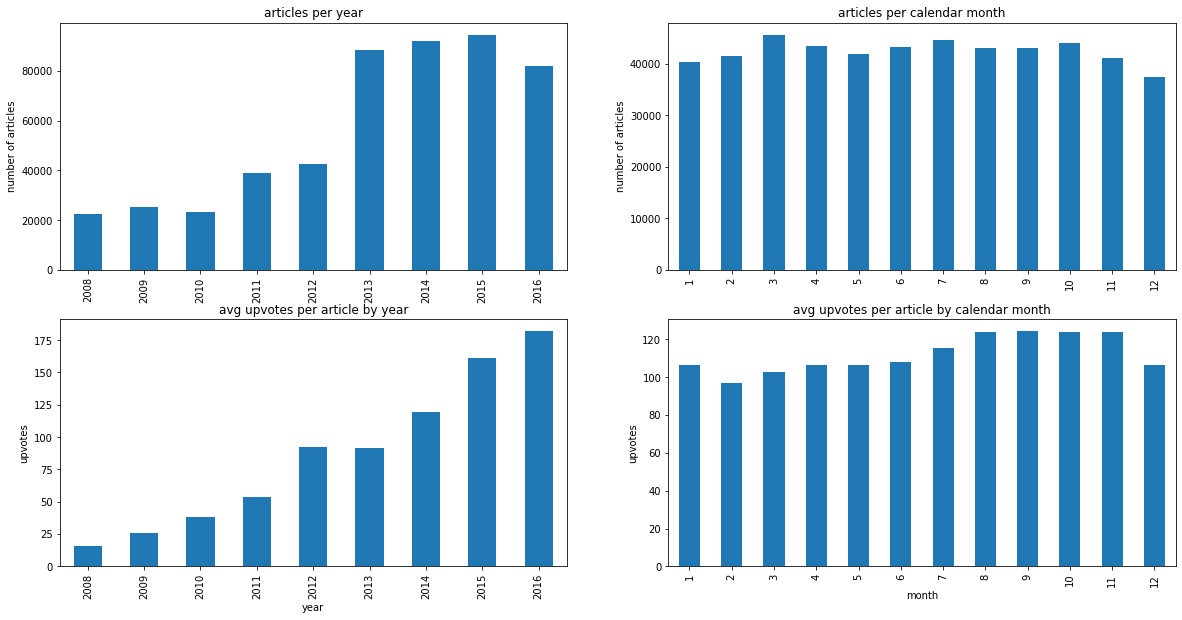

In [6]:
# analysis of titles and upvotes by month/year

plt.figure(figsize=(20,10))

plt.subplot(221);
raw_df.year.value_counts().sort_index().plot.bar()
plt.title('articles per year')
plt.ylabel('number of articles')

plt.subplot(222);
raw_df.month.value_counts().sort_index().plot.bar()
plt.title('articles per calendar month')
plt.ylabel('number of articles')

plt.subplot(223);
raw_df.groupby('year').up_votes.mean().plot.bar()
plt.title('avg upvotes per article by year')
plt.ylabel('upvotes')

plt.subplot(224);
raw_df.groupby('month').up_votes.mean().plot.bar()
plt.title('avg upvotes per article by calendar month')
plt.ylabel('upvotes')

plt.show()

Hypotheses around increasing upvotes over time:

- more total readers
- more readers switched from print to digital (where upvotes can be recorded)
- writers/editors apply DS to learn which stories users like
- 

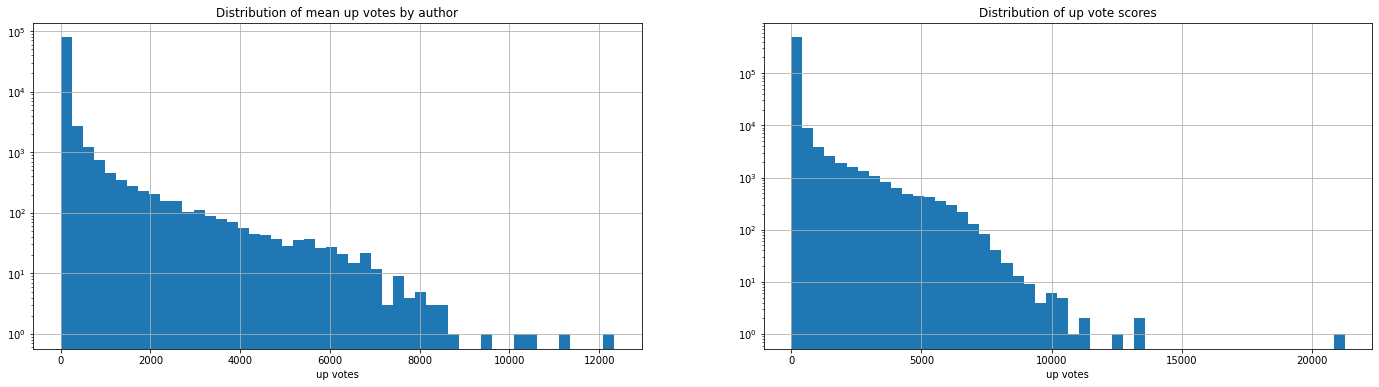

In [122]:
# looking at dists of upvote scores
plt.figure(figsize=(24,6))

plt.subplot(121);
raw_df.groupby('author').up_votes.mean().hist(bins=50)
plt.yscale('log')
plt.title('Distribution of mean up votes by author')
plt.xlabel('up votes')

plt.subplot(122);
raw_df.up_votes.hist(bins=50)
plt.yscale('log')
plt.title('Distribution of up vote scores')
plt.xlabel('up votes')

plt.show()

In [95]:
# clean up titles
NON_ALPHANUM = re.compile(r'[\W]') #this gets rid of periods, which may be good for things like U.N.. but not all instances of U.N. have periods
NON_ASCII = re.compile(r'[^a-z0-1\s]')
def clean_texts(texts):
  lower = texts.lower()
  # no_hyphens = re.compile(r'[-]').sub('', lower)
  no_dots = re.compile(r'[.]').sub('', lower)
  # no_brackets = re.compile(r'\[.*]').sub('', no_dots)
  no_punctuation = NON_ALPHANUM.sub(r' ', no_dots)
  no_non_ascii = NON_ASCII.sub(r'', no_punctuation)
  return no_non_ascii

raw_df['title_cleaned'] = raw_df.title.apply(clean_texts)

raw_df.title_cleaned = raw_df.title_cleaned.apply(lambda x: " ".join(x.strip().split()))

In [98]:
### headline focused analysis

raw_df['tokens'] = raw_df.title_cleaned.apply(lambda x: x.split())

raw_df['title_length'] = raw_df.tokens.str.len()

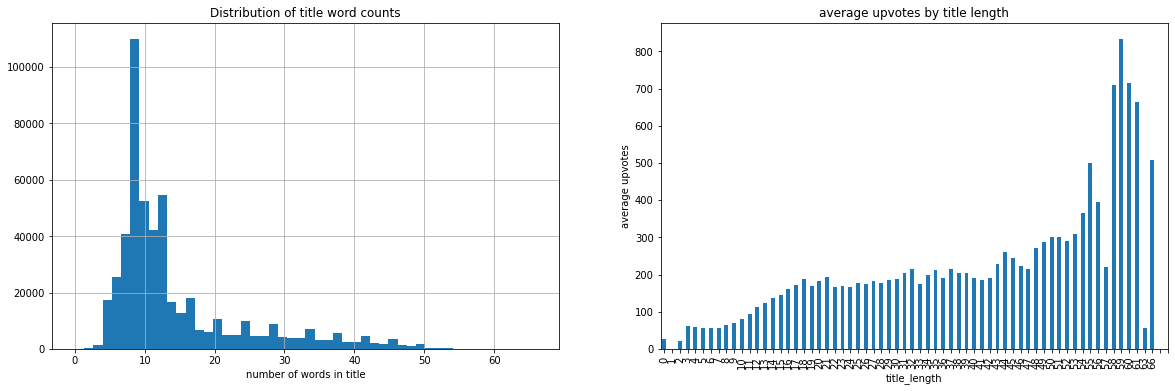

In [10]:
# analysis of title lengths and upvotes

plt.figure(figsize=(20,6))

plt.subplot(121)
raw_df.title_length.hist(bins=50)
plt.xlabel('number of words in title')
plt.title('Distribution of title word counts')

plt.subplot(122)
raw_df.groupby('title_length').up_votes.mean().plot.bar()
plt.title('average upvotes by title length')
plt.ylabel('average upvotes')
plt.xticks(np.arange(0,66), rotation=90)


plt.show()

This is **VERY** interesting. At first it looks like there's a clear positive correlation between title length and number of upvotes.

But if you look at the histogram (above, left) you can see that there are very few title with more than 50 words. So there may still be a correlation, but there may be something fishy going on with those fewer instances with lots of words in the titles.

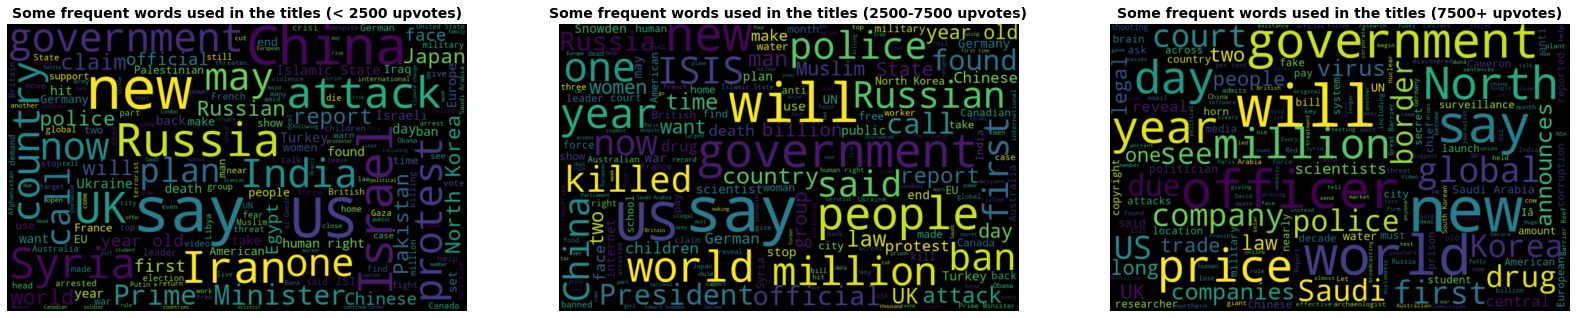

In [12]:
# generate word clouds by low/med/hi up vote counts

all_words_low_vote = ''.join([word for word in raw_df.loc[raw_df.up_votes < 2500,'title']])
wordcloud_low_vote = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words_low_vote)

all_words_med_vote = ''.join([word for word in raw_df.loc[(raw_df.up_votes >= 2500) & (raw_df.up_votes < 7500),'title']])
wordcloud_med_vote = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words_med_vote)

all_words_hi_vote = ''.join([word for word in raw_df.loc[raw_df.up_votes > 7500,'title']])
wordcloud_hi_vote = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words_hi_vote)


# plot wordclouds
plt.figure(figsize=(28, 7))
plt.subplot(131)
plt.imshow(wordcloud_low_vote, interpolation="bilinear")
plt.axis('off')
plt.title("Some frequent words used in the titles (< 2500 upvotes)", weight='bold', fontsize=14)

plt.subplot(132)
plt.imshow(wordcloud_med_vote, interpolation="bilinear")
plt.axis('off')
plt.title("Some frequent words used in the titles (2500-7500 upvotes)", weight='bold', fontsize=14)

plt.subplot(133)
plt.imshow(wordcloud_hi_vote, interpolation="bilinear")
plt.axis('off')
plt.title("Some frequent words used in the titles (7500+ upvotes)", weight='bold', fontsize=14)
plt.show()

In [99]:
# clean up the dataset

cleaned_df = raw_df.loc[raw_df.title_length > 0]

In [90]:
cleaned_df.head()

,time_created,date_created,up_votes,down_votes,title,over_18,author,category,year,month_year,month,title_cleaned,tokens,title_length
0,1201232046,2008-01-25,3,0,Scores killed in Pakistan clashes,False,polar,worldnews,2008,2008-01,1,scores killed in pakistan clashes,"[scores, killed, in, pakistan, clashes]",5
1,1201232075,2008-01-25,2,0,Japan resumes refuelling mission,False,polar,worldnews,2008,2008-01,1,japan resumes refuelling mission,"[japan, resumes, refuelling, mission]",4
2,1201232523,2008-01-25,3,0,US presses Egypt on Gaza border,False,polar,worldnews,2008,2008-01,1,us presses egypt on gaza border,"[us, presses, egypt, on, gaza, border]",6
3,1201233290,2008-01-25,1,0,Jump-start economy: Give health care to all,False,fadi420,worldnews,2008,2008-01,1,jump start economy give health care to all,"[jump, start, economy, give, health, care, to,...",8
4,1201274720,2008-01-25,4,0,Council of Europe bashes EU&UN terror blacklist,False,mhermans,worldnews,2008,2008-01,1,council of europe bashes eu un terror blacklist,"[council, of, europe, bashes, eu, un, terror, ...",8


# 2. Topic Modeling

---

start with some cleaning

In [12]:
# lets work with a subsample for this section since training/evaluating takes a lot of time

cleaned_df_sampled = cleaned_df.sample(frac=0.1, random_state=87)

In [13]:
# remove stop words
stop = stopwords.words('english')
cleaned_df_sampled['no_stop_tokens'] = cleaned_df_sampled.tokens.apply(lambda title: [word for word in title if word not in stop])

# lemmatize words
lmtzr = WordNetLemmatizer()
cleaned_df_sampled['lemma_tokens'] = cleaned_df_sampled.no_stop_tokens.apply(lambda title: [lmtzr.lemmatize(word) for word in title])

In [14]:
# get nostop title
cleaned_df_sampled['nostop_title'] = cleaned_df_sampled.no_stop_tokens.apply(lambda x: ' '.join(x))

# length of nostop titles
cleaned_df_sampled['title_length_nostop'] = cleaned_df_sampled.no_stop_tokens.str.len()

In [15]:
cleaned_df_topics = cleaned_df_sampled.loc[cleaned_df_sampled.title_length_nostop >= 3].copy()

top2vec: out of box topic modeling with transformer

In [ ]:
!pip install tensorflow tensorflow_hub tensorflow_text

In [16]:
# run model on cleaned titles
titles = cleaned_df_topics.nostop_title.values.tolist()

start_time = time.time()
model_reviews = Top2Vec(documents=titles, embedding_model='universal-sentence-encoder')
print('Total time taken (mins): ', int((time.time()-start_time)/60))

2021-04-15 01:01:15,708 - top2vec - INFO - Pre-processing documents for training
2021-04-15 01:01:18,146 - top2vec - INFO - Downloading universal-sentence-encoder model
INFO:absl:Using /tmp/tfhub_modules to cache modules.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder/4'.
INFO:absl:Downloaded https://tfhub.dev/google/universal-sentence-encoder/4, Total size: 987.47MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder/4'.
2021-04-15 01:01:35,599 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2021-04-15 01:01:41,582 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2021-04-15 01:03:07,458 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2021-04-15 01:03:12,771 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics


Total time taken (mins):  1


In [17]:
print('number of topics: {}'.format(model_reviews.get_num_topics()))

topic_nums,_,_,_ = model_reviews.get_documents_topics(model_reviews.document_ids)

cleaned_df_topics['top2vec_topic'] = topic_nums

number of topics: 220


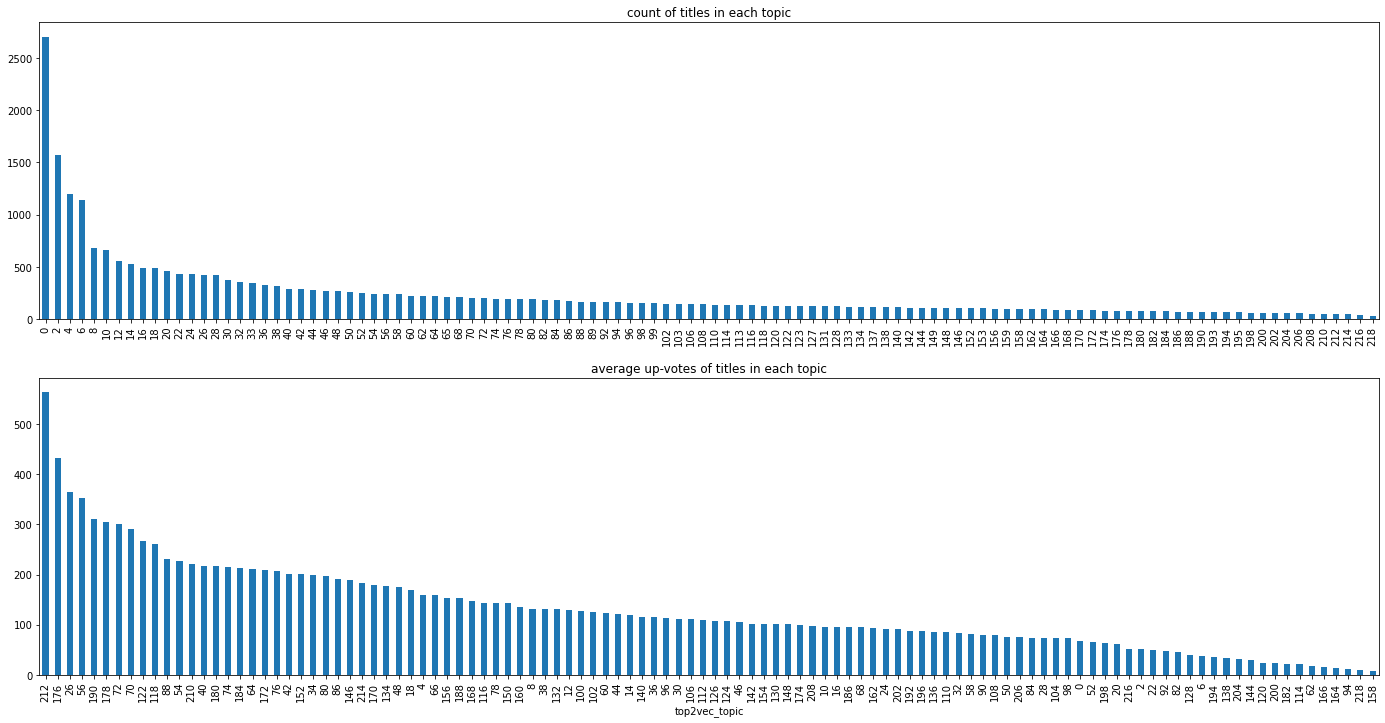

In [18]:
plt.figure(figsize=(24,12))

plt.subplot(211)
cleaned_df_topics.top2vec_topic.value_counts()[::2].plot.bar()
plt.title('count of titles in each topic')

plt.subplot(212)
cleaned_df_topics.groupby('top2vec_topic').up_votes.mean()[::2].sort_values(ascending=False).plot.bar()
plt.title('average up-votes of titles in each topic')

plt.show()


interesting. some topics have titles with much higher average upvotes that others.

lets compare some of the words from each topic in wordclouds

In [ ]:
model_reviews.generate_topic_wordcloud(topic_num=56)

In [ ]:
model_reviews.generate_topic_wordcloud(topic_num=2)

In [ ]:
model_reviews.generate_topic_wordcloud(topic_num=6)

### Once we have trained this embeddings model, we can do some cool searching with it:

In [20]:
# sanity check
words, word_scores = model_reviews.similar_words(keywords=["spain"], keywords_neg=[], num_words=10)
for word, score in zip(words, word_scores):
    print(f"{word} {score}")

france 0.5974177152179083
germany 0.5823795614117694
mexico 0.5651307665309527
england 0.5648059032483959
spanish 0.5585624060390728
italy 0.5328279885351174
argentina 0.5182498991134814
netherlands 0.5033583431802514
catalonia 0.5028478345691986
britain 0.4990374492314203


In [38]:
# find titles similar to any given keyword

my_keywords = ['football']


documents, document_scores, document_ids_football = model_reviews.search_documents_by_keywords(keywords=my_keywords, num_docs=10)
for doc, score, doc_id in zip(documents, document_scores, document_ids_football):
    print(f"Document: {doc_id}, Score: {score}")
    print("-----------")
    print(doc)
    print()

Document: 39442, Score: 0.4719800113264492
-----------
god bless america football soccer fans around world well

Document: 47, Score: 0.42560663549387645
-----------
football first bulgarian ex premier

Document: 40519, Score: 0.4029775509528304
-----------
league rohingya footballers tackle prejudice malaysia

Document: 39263, Score: 0.3993379555853488
-----------
brain controlled kick open year world cup soccer

Document: 4871, Score: 0.38850015035852115
-----------
turkey fires football referees

Document: 48052, Score: 0.3729687118058832
-----------
london 01 games women sport

Document: 1748, Score: 0.3706190523409085
-----------
qatar world cup

Document: 48540, Score: 0.3692762283766832
-----------
spanish football politics palestine

Document: 44552, Score: 0.36478159655882375
-----------
police clash england fans arrests football

Document: 6828, Score: 0.35622243176230606
-----------
baseball bats selling uk



In [41]:
# find titles similar to any given keyword

my_keywords = ['police']

documents, document_scores, document_ids_police = model_reviews.search_documents_by_keywords(keywords=my_keywords, num_docs=10)
for doc, score, doc_id in zip(documents, document_scores, document_ids_police):
    print(f"Document: {doc_id}, Score: {score}")
    print("-----------")
    print(doc)
    print()

Document: 37519, Score: 0.4814754023167591
-----------
suspect police radar

Document: 15560, Score: 0.46490253048690955
-----------
uk police forces disproportionate number white officers

Document: 19341, Score: 0.45750947546836873
-----------
rise police brutality killer cops

Document: 21760, Score: 0.44300691469159287
-----------
police make computer hijack arrests

Document: 3694, Score: 0.43861006178095074
-----------
black people likely tasered police force admits

Document: 27712, Score: 0.4186244390808894
-----------
police cars ablaze london riot

Document: 41622, Score: 0.4124857535548705
-----------
uk police may attend bulgaries

Document: 8608, Score: 0.4104216848182807
-----------
police respond attack american university

Document: 12366, Score: 0.40131294547072544
-----------
police make arrest alps killings

Document: 37854, Score: 0.40068207439872006
-----------
police allege man sexually assaulted women



In [42]:
# check which topics these titles fall under

topic_nums,_,_,_ = model_reviews.get_documents_topics(document_ids_football)
print('football topics:', topic_nums)

topic_nums,_,_,_ = model_reviews.get_documents_topics(document_ids_police)
print('police topics:', topic_nums)

# several/many of the results come from within the same topic

football topics: [170 170 101 171  18  39 171  82 136  31]
police topics: [ 31  31  31  31  31 136  31  31  31  40]


# 3. Sentiment Analysis

---

continue with same subset

In [ ]:
# !pip install transformers

from transformers import pipeline
# hf_sentiment = pipeline('sentiment-analysis')
hf_sentiment2 = pipeline('sentiment-analysis', model="nlptown/bert-base-multilingual-uncased-sentiment")

In [72]:
hf_sentiment('i am a little happy and but am greatly sad')

[{'label': 'NEGATIVE', 'score': 0.957980751991272}]

In [ ]:
cleaned_df_topics['sentiment'] = cleaned_df_topics.title_cleaned.apply(lambda x: hf_sentiment(x))

In [160]:
cleaned_df_topics['sentiment_posneg'] = cleaned_df_topics.sentiment.apply(lambda x: x[0]['label'])
cleaned_df_topics['sentiment_score'] = cleaned_df_topics.sentiment.apply(lambda x: x[0]['score'])

# make negative scores negative
cleaned_df_topics.loc[cleaned_df_topics.sentiment_posneg == 'NEGATIVE', 'sentiment_score'] = cleaned_df_topics.sentiment_score * -1

In [177]:
cleaned_df_topics.head()

,time_created,date_created,up_votes,down_votes,title,over_18,author,category,year,month_year,month,title_cleaned,tokens,title_length,no_stop_tokens,lemma_tokens,nostop_title,title_length_nostop,top2vec_topic,sentiment,sentiment_posneg,sentiment_score
503158,1477655770,2016-10-28,48,0,Worst of times for the butterfly - The scienti...,False,anutensil,worldnews,2016,2016-10,10,worst of times for the butterfly the scienti...,"[worst, of, times, for, the, butterfly, the, s...",31,"[worst, times, butterfly, scientific, numbers,...","[worst, time, butterfly, scientific, number, y...",worst times butterfly scientific numbers yet u...,18,3,"[{'label': 'NEGATIVE', 'score': 0.999727249145...",NEGATIVE,-0.999727
161759,1361536407,2013-02-22,1,0,Egyptian elections to start in April,False,MiamiHigh_Yoshi_,worldnews,2013,2013-02,2,egyptian elections to start in april,"[egyptian, elections, to, start, in, april]",6,"[egyptian, elections, start, april]","[egyptian, election, start, april]",egyptian elections start april,4,16,"[{'label': 'POSITIVE', 'score': 0.925417006015...",POSITIVE,0.925417
94481,1311512884,2011-07-24,598,0,"Norwegians defy gunman by sticking to open, to...",False,DougisonFire,worldnews,2011,2011-07,7,norwegians defy gunman by sticking to open to...,"[norwegians, defy, gunman, by, sticking, to, o...",9,"[norwegians, defy, gunman, sticking, open, tol...","[norwegian, defy, gunman, sticking, open, tole...",norwegians defy gunman sticking open tolerant ...,7,27,"[{'label': 'POSITIVE', 'score': 0.994825720787...",POSITIVE,0.994826
119098,1333714880,2012-04-06,5,0,"Malawi president dies, leaving nation in polit...",False,syuk,worldnews,2012,2012-04,4,malawi president dies leaving nation in polit...,"[malawi, president, dies, leaving, nation, in,...",8,"[malawi, president, dies, leaving, nation, pol...","[malawi, president, dy, leaving, nation, polit...",malawi president dies leaving nation political...,7,0,"[{'label': 'NEGATIVE', 'score': 0.952219307422...",NEGATIVE,-0.952219
148978,1354716411,2012-12-05,36,0,Germany Might Be Pulling Off Another Economic ...,False,maxwellhill,worldnews,2012,2012-12,12,germany might be pulling off another economic ...,"[germany, might, be, pulling, off, another, ec...",8,"[germany, might, pulling, another, economic, m...","[germany, might, pulling, another, economic, m...",germany might pulling another economic miracle,6,3,"[{'label': 'POSITIVE', 'score': 0.924753069877...",POSITIVE,0.924753


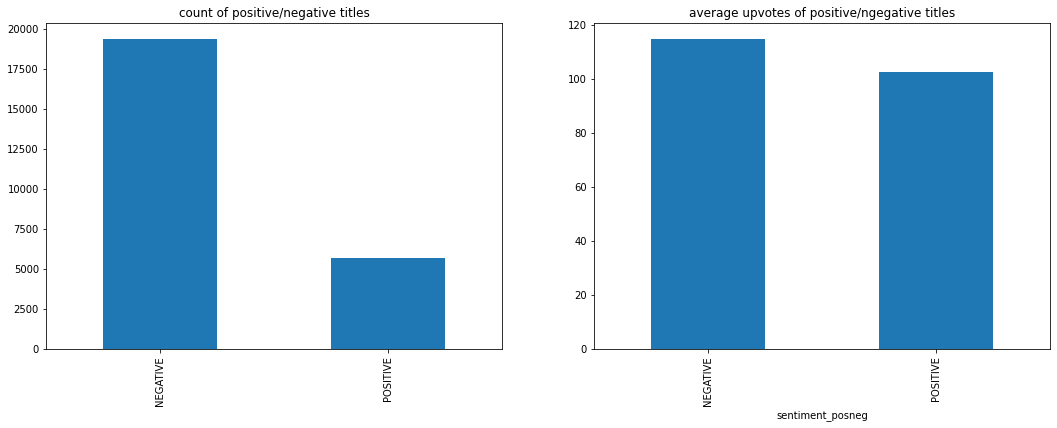

In [180]:
# basic look at sentiment labels

plt.figure(figsize=(18,6))

plt.subplot(121)
cleaned_df_topics.sentiment_posneg.value_counts().plot.bar()
plt.title('count of positive/negative titles')

plt.subplot(122)
cleaned_df_topics.groupby('sentiment_posneg').up_votes.mean().plot.bar()
plt.title('average upvotes of positive/ngegative titles')

plt.show()

Text(0.5, 1.0, 'Title upvotes vs. sentiment score magnitude')

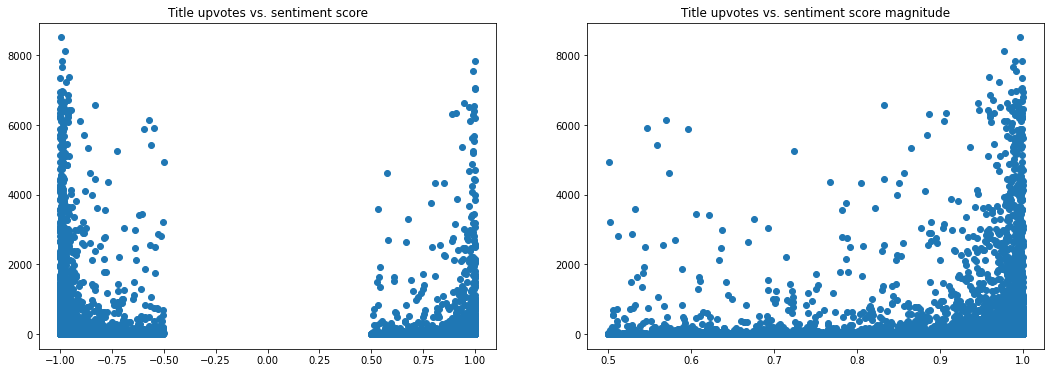

In [179]:
# looking at up votes vs sentiment scores

plt.figure(figsize=(18,6))

plt.subplot(121)
plt.scatter(cleaned_df_topics.sentiment_score, cleaned_df_topics.up_votes)
plt.title('Title upvotes vs. sentiment score')

plt.subplot(122)
plt.scatter(abs(cleaned_df_topics.sentiment_score), cleaned_df_topics.up_votes)
plt.title('Title upvotes vs. sentiment score magnitude')

WOW!!! This is really insightful. Not sure why the scores are only > 0.5 in magnitude, but...

most of the highest upvoted titles are either extremely positive or extremely negative. This makes sense intuitively!!

Text(0.5, 1.0, 'Title upvotes vs. sentiment score')

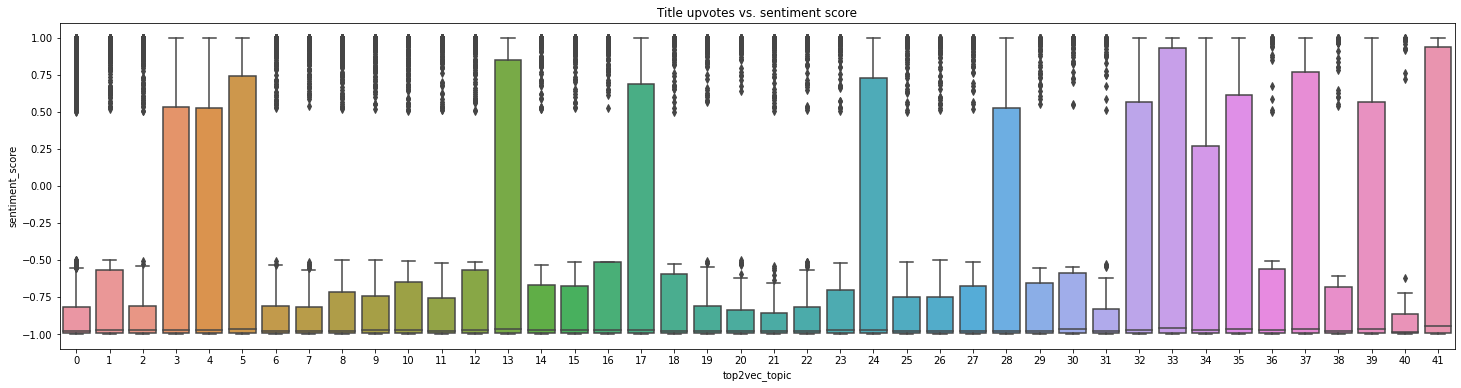

In [192]:
# looking at sentiment scores by topic
plt.figure(figsize=(25,6))

sns.boxplot(data=cleaned_df_topics, x='top2vec_topic', y='sentiment_score')
plt.title('Title upvotes vs. sentiment score')



on average, the titles within most topics tend to have very negative sentiment. Some clusters (3,4,5,13,17,...) have significant number of positive titles, compared to other topics in which the positive titles are deemed to be outliers.

# Text Generation

---

with more time, I would get this to work.
The idea is to finetune a language model (BERT, GPT-2) on the titles that get high-upvotes. The idea is to get help from an AI on generating popular titles for an article/reddit post/etc.

In [115]:
!git clone https://github.com/alontalmor/pytorch-transformers.git

Cloning into 'pytorch-transformers'...
remote: Enumerating objects: 10467, done.
remote: Total 10467 (delta 0), reused 0 (delta 0), pack-reused 10467
Receiving objects: 100% (10467/10467), 5.35 MiB | 23.43 MiB/s, done.
Resolving deltas: 100% (7617/7617), done.


In [84]:

less10 = cleaned_df[cleaned_df.up_votes < 10].shape[0]
more10 = cleaned_df[cleaned_df.up_votes >= 10].shape[0]

print('{} titles with less than 10 upvotes, {} titles with 10 or more'.format(less10, more10))

339055 titles with less than 10 upvotes, 170156 titles with 10 or more


In [109]:
hi_votes_df = cleaned_df[cleaned_df.up_votes >= 10]

msk = np.random.rand(len(hi_votes_df)) < 0.9

hi_votes_titles_train = hi_votes_df[msk].title_cleaned.str.cat(sep='. ')
hi_votes_titles_test = hi_votes_df[~msk].title_cleaned.str.cat(sep='. ')




In [114]:
f = open("hi_votes_titles_train.raw", "x")
f.write(hi_votes_titles_train)
f.close()

g = open("hi_votes_titles_test.raw", "x")
g.write(hi_votes_titles_test)
g.close()

In [116]:
output = ''

In [118]:
from transformers import get_linear_schedule_with_warmup

In [120]:
!export TRAIN_FILE=hi_votes_titles_train.raw
!export TEST_FILE=hi_votes_titles_test.raw

!python pytorch-transformers/examples/run_lm_finetuning.py \
    --output_dir=output \
    --model_type=gpt2 \
    --model_name_or_path=gpt2 \
    --do_train \
    --train_data_file=$TRAIN_FILE \
    --do_eval \
    --eval_data_file=$TEST_FILE

2021-04-15 02:19:38.278943: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
04/15/2021 02:19:39 - WARNING - __main__ -   Process rank: -1, device: cpu, n_gpu: 0, distributed training: False, 16-bits training: False
04/15/2021 02:19:40 - INFO - filelock -   Lock 140364882258128 acquired on /root/.cache/huggingface/transformers/fc674cd6907b4c9e933cb42d67662436b89fa9540a1f40d7c919d0109289ad01.7d2e0efa5ca20cef4fb199382111e9d3ad96fd77b849e1d4bed13a66e1336f51.lock
Downloading: 100% 665/665 [00:00<00:00, 538kB/s]
04/15/2021 02:19:40 - INFO - filelock -   Lock 140364882258128 released on /root/.cache/huggingface/transformers/fc674cd6907b4c9e933cb42d67662436b89fa9540a1f40d7c919d0109289ad01.7d2e0efa5ca20cef4fb199382111e9d3ad96fd77b849e1d4bed13a66e1336f51.lock
04/15/2021 02:19:40 - INFO - filelock -   Lock 140365086821776 acquired on /root/.cache/huggingface/transformers/684fe667923972fb57f6b4dcb61a3c92763ad89882f3da5da9866baf1

In [ ]:
!python run_generation.py \
    --model_type=gpt2 \
    --model_name_or_path=gpt2

# Other/unused code

---

### manual topic modeling

In [ ]:
#1: get pretrainedword2vec embeddings

pretrained_embeddings_path = "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
word2vec_pt = KeyedVectors.load_word2vec_format(pretrained_embeddings_path, binary=True)

This is a word2vec model that was pretrained on google news sources. This could be a good model for this purpose since the titles are essentially some form of news headline. 

According to [this post](https://stackoverflow.com/questions/58155131/how-to-pre-process-texts-to-match-googles-pre-trained-word2vec-model) google news words weren't lemmatized before training. so lets get the vectors of unlemmatized words from the pretrained model

In [ ]:
# title embeddings as mean of pretrained word embeddings

titles_df['pretrained_vector'] = titles_df.no_stop_tokens.apply(lambda tokens: np.mean([word2vec_pt[word] if word in word2vec_pt else np.zeros(300) for word in tokens], axis=0))

In [ ]:
#2: train our own word2vec embeddings

#sg=0 uses cbow. ordering of words is NOT taken into account. sometimes headlines have weird ordering. just intuition for now, could be tested/researched with more time.
# trying smaller vector size, recommended for shorter sentences
# smaller window size also fits with shorter sentences

word2vec_my = Word2Vec(sentences=titles_df.lemma_tokens.values.tolist(), sg=1, size=100, window=3, min_count=1, workers=4)

In [ ]:
# title embeddings as mean of self-trained word embeddings

titles_df['selftrained_vector'] = titles_df.lemma_tokens.apply(lambda tokens: np.mean([word2vec_my.wv[word] for word in tokens], axis=0))

Topic Modeling:
can use LDA (Latent Dirichlet Allocation), but it requires number of latent features/topics as input

Hierarchical Dirichlet Process is ideal when we don't know the number of topics beforehand. However, due to limited time I will go with the simpler option of LDA. In this case I think it's ok since we are already limited to world news.

In [ ]:
# get vectors into array for LDA clustering

pretrained_vectors = np.array(titles_df.pretrained_vector.values.tolist())

selftrained_vectors = np.array(titles_df.selftrained_vector.values.tolist())

LDA can't take negative values. not sure if standardizing to positive (0-1) would break some of the distances

In [ ]:
# LSA (svn) model
# lets go with 12 topics. just intuition.
lsa_model = TruncatedSVD(n_components=12, random_state=87)

# apply to pretrained. latent column with highest value will be the assigned topic
topics_pre = lsa_model.fit_transform(pretrained_vectors)
pre_title_topics = np.argmax(topics_pre, axis=1)

# apply to self trained
topics_self = lsa_model.fit_transform(selftrained_vectors)
self_title_topics = np.argmax(topics_self, axis=1)

In [ ]:
titles_df['pre_topic'] = pre_title_topics

titles_df['self_topic'] = self_title_topics

In [ ]:
# find a description of the topics
# taking wayy to long. try with subsampling

words_per_topic = titles_df.sample(frac=0.05).groupby('pre_topic').lemma_tokens.sum()




In [ ]:
titles_df.pre_topic.value_counts()

In [ ]:
titles_df.self_topic.value_counts()

The LSA results are really bad. everything is going to one topic.

[this study](https://medium.com/analytics-vidhya/topic-modelling-using-word-embeddings-and-latent-dirichlet-allocation-3494778307bc) gets seemingly decent results clustering word2vec embeddings with kmeans

In [ ]:
km_pre = KMeans(n_clusters=12, random_state=0).fit(pretrained_vectors)

titles_df['pre_km_topics'] = km_pre.labels_

titles_df.pre_km_topics.value_counts()

In [ ]:
from sklearn.manifold import TSNE

# subsample vectors and reduce to two dimension for visualizing the clusters

tsne_pre = TSNE(n_components=2, random_state=87).fit_transform(pretrained_vectors[::50])

^^ this is taking forever

In [ ]:
plt.figure(figsize=(12,6))
plt.scatter(x=tsne_pre[:,0], y=tsne_pre[:,1], c=km_pre)
plt.title('t-sne reduced pretrained vectors with topics')
plt.show()

In [ ]:
km_self = KMeans(n_clusters=12, random_state=0).fit(selftrained_vectors)

There are so many different options to try. And this dataset is very large so running tests takes a long time. 

I could try different vectorizers: one hot encoded, tf-idf, word2vec, doc2vec

I could try LDA, LSA, any clustering technique

I could try dimensionality techniques on the vectors before clustering (PCA, ICA, random components, etc)


With more time I could spend time reading research papers and experimenting to find good topic modeling techniques. For now I'll just go with the k-means clusters for topics.

In [ ]:
# generate word clouds by low/med/hi word count

all_words_low = ''.join([word for word in raw_df.loc[raw_df.title_length < 10,'title']])
wordcloud_low = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words_low)

all_words_med = ''.join([word for word in raw_df.loc[(raw_df.title_length >= 10) & (raw_df.title_length < 25),'title']])
wordcloud_med = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words_med)

all_words_hi = ''.join([word for word in raw_df.loc[raw_df.title_length > 25,'title']])
wordcloud_hi = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words_hi)


## plot wordclouds
plt.figure(figsize=(28, 7))
plt.subplot(131)
plt.imshow(wordcloud_low, interpolation="bilinear")
plt.axis('off')
plt.title("Some frequent words used in the short titles (< 10 words)", weight='bold', fontsize=14)

plt.subplot(132)
plt.imshow(wordcloud_med, interpolation="bilinear")
plt.axis('off')
plt.title("Some frequent words used in the titles (10-24 words)", weight='bold', fontsize=14)

plt.subplot(133)
plt.imshow(wordcloud_hi, interpolation="bilinear")
plt.axis('off')
plt.title("Some frequent words used in the titles (25+ words)", weight='bold', fontsize=14)
plt.show()